In [1]:
import argparse
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.utils.data as dt
from model import MultiLayerPerceptron
from dataset import AdultDataset
from util import *
from scipy.signal import savgol_filter

In [2]:
# Hyperparameters
seed = 10
bs = 64 # Batch size
hidden_size = 64  
learn_rate = 0.1 
epochs = 20 
N = 10 # N steps
numLayers = 2
act_fcn = "relu" # 'sigmoid' for sigmoid, 'tanh' for tanh
ts = 0.2 # test size parameter in test-train split

In [3]:
# 3.1: load dataset
data = pd.read_csv("./data/adult.csv")

In [4]:
# 3.2: data visualization
print("Shape: " + str(data.shape))
print(data.columns)
verbose_print(data.head())
print(data["income"].value_counts())

Shape: (48842, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2  

In [5]:
# 3.3: data cleaning
col_names = data.columns
num_rows = data.shape[0]
for feature in col_names:
    print(feature + ": " + str(data[feature].isin(["?"]).sum()))
# From results of for loop, can directly index columns
data = data[data["workclass"] != "?"]
data = data[data["occupation"] != "?"]
data = data[data["native-country"] != "?"]
print("Shape: " + str(data.shape))

age: 0
workclass: 2799
fnlwgt: 0
education: 0
educational-num: 0
marital-status: 0
occupation: 2809
relationship: 0
race: 0
gender: 0
capital-gain: 0
capital-loss: 0
hours-per-week: 0
native-country: 857
income: 0
Shape: (45222, 15)


In [6]:
# 3.4: balance the dataset
dim = min(data["income"].value_counts())
high_inc = data.loc[data["income"] == ">50K"]
low_inc = data.loc[data["income"] == "<=50K"]
low_inc = low_inc.sample(n=dim, random_state=seed)
data = pd.concat([low_inc,high_inc])

                age         fnlwgt  educational-num  capital-gain  \
count  22416.000000   22416.000000     22416.000000  22416.000000   
mean      40.377409  189391.504729        10.621922   2067.610011   
std       12.570407  104908.241869         2.591625  10531.800989   
min       17.000000   13769.000000         1.000000      0.000000   
25%       31.000000  117674.000000         9.000000      0.000000   

       capital-loss  hours-per-week  
count  22416.000000    22416.000000  
mean     122.007985       42.511777  
std      475.827147       11.887556  
min        0.000000        1.000000  
25%        0.000000       40.000000  

Private             15785
Self-emp-not-inc     1977
Local-gov            1680
Self-emp-inc         1148
State-gov             988
Federal-gov           830
Without-pay             8
Name: workclass, dtype: int64

White                 19672
Black                  1714
Asian-Pac-Islander      707
Amer-Indian-Eskimo      177
Other                   146
Nam

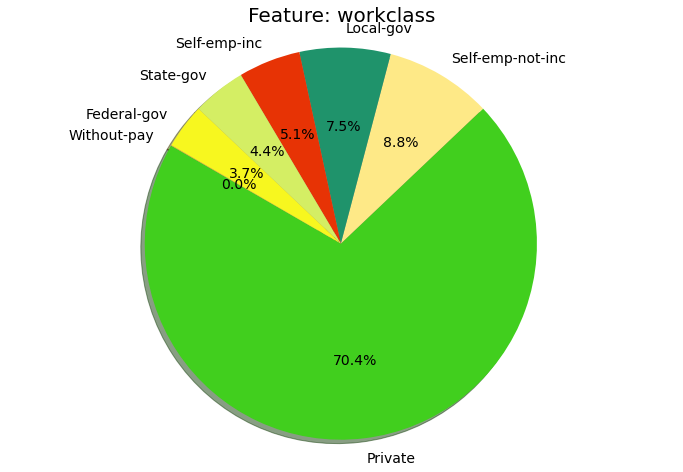

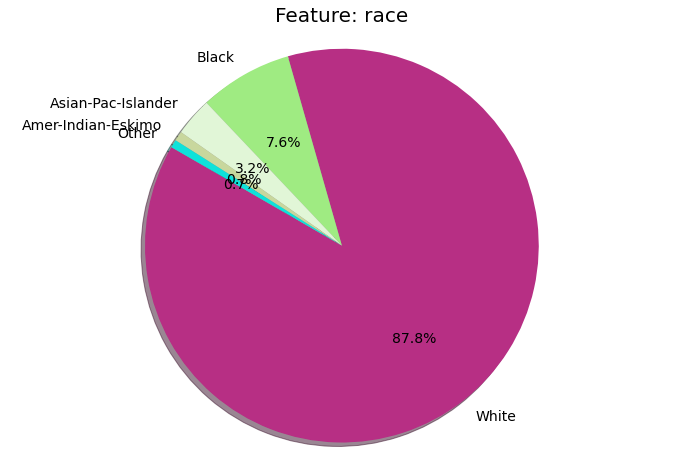

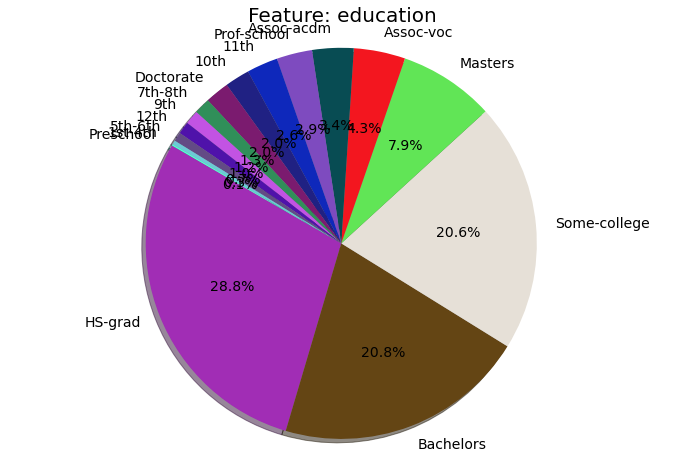

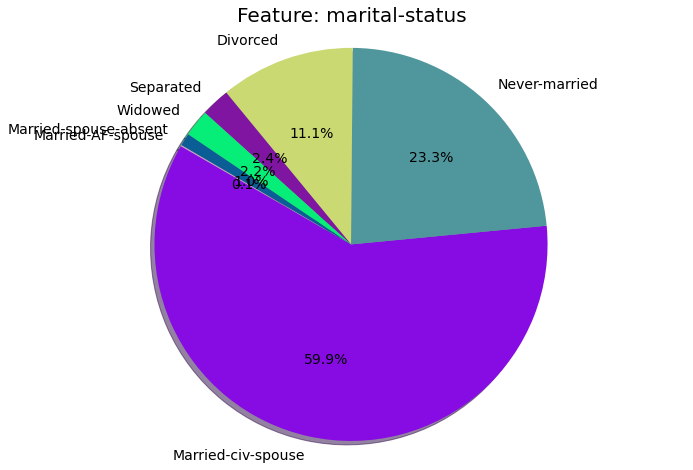

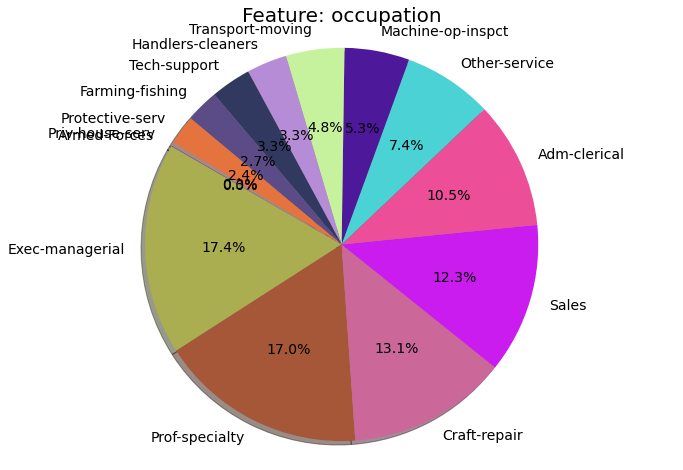

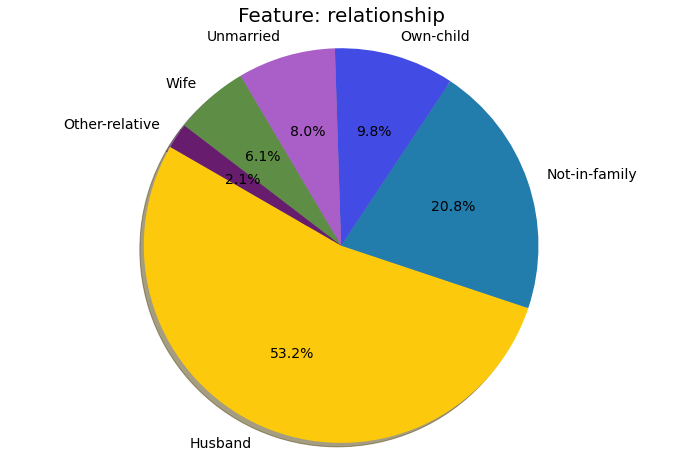

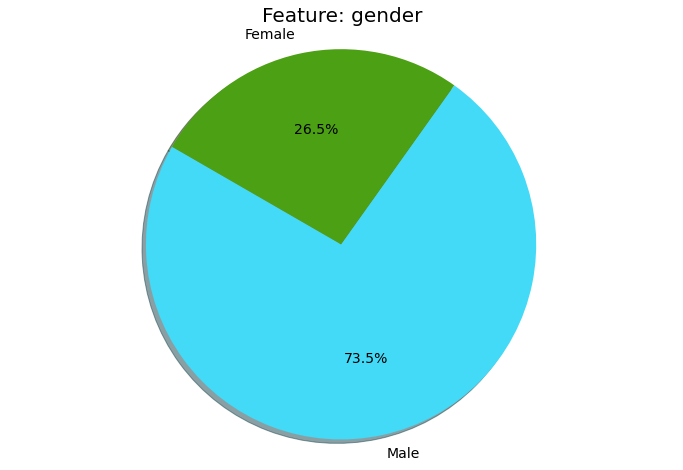

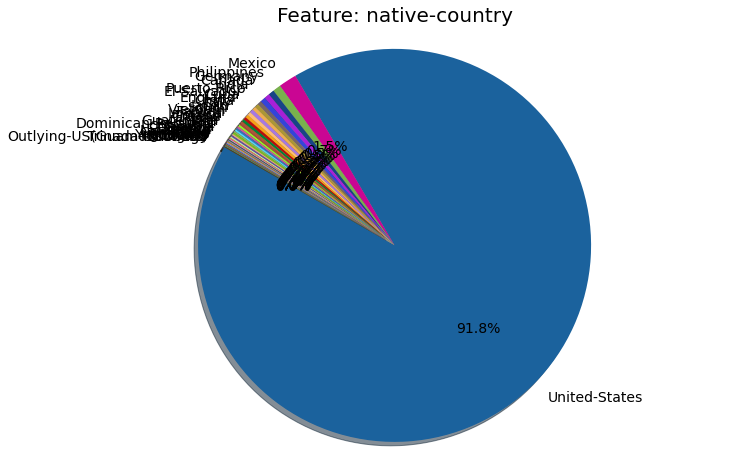

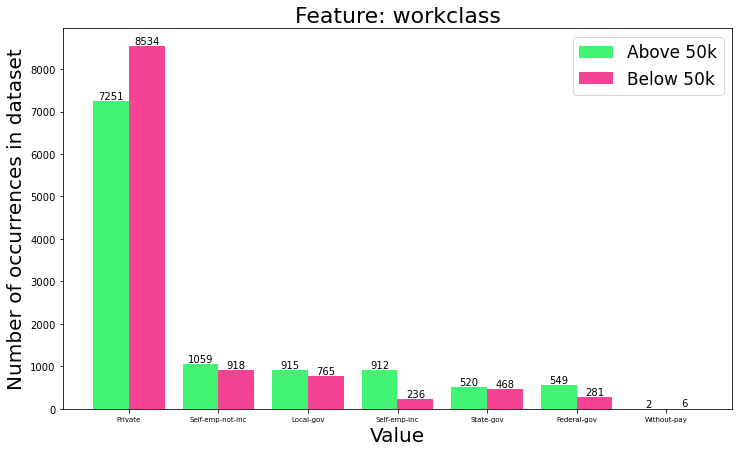

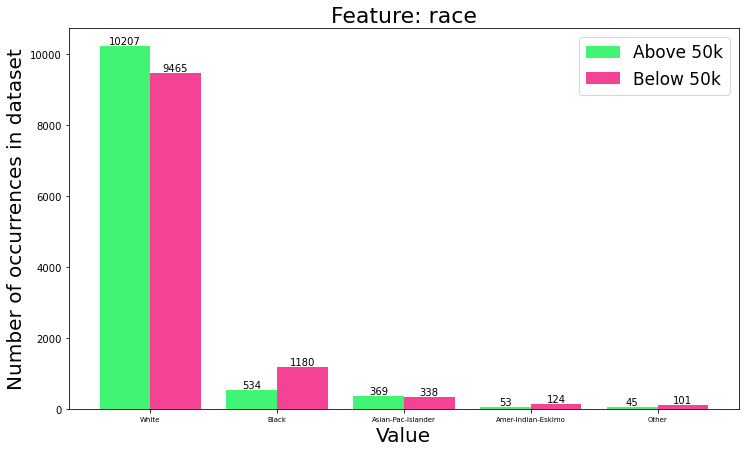

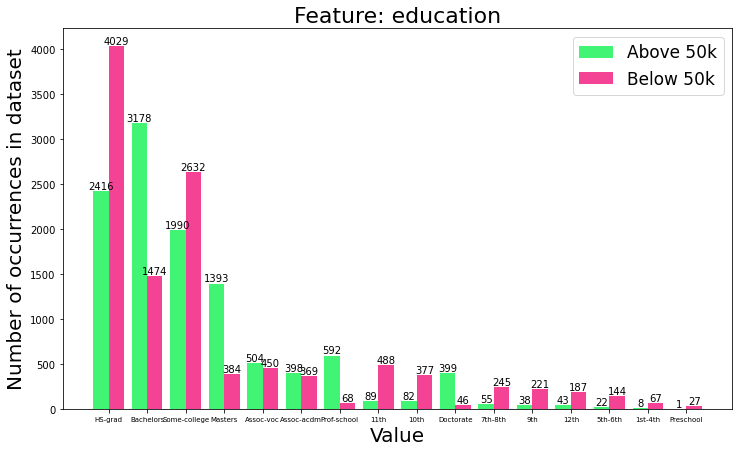

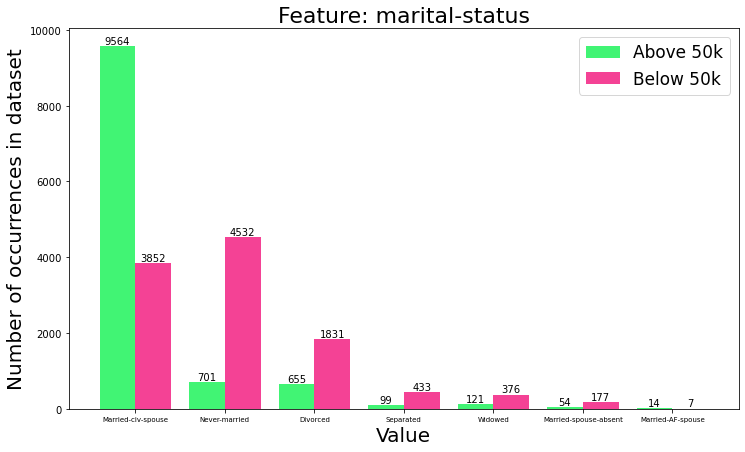

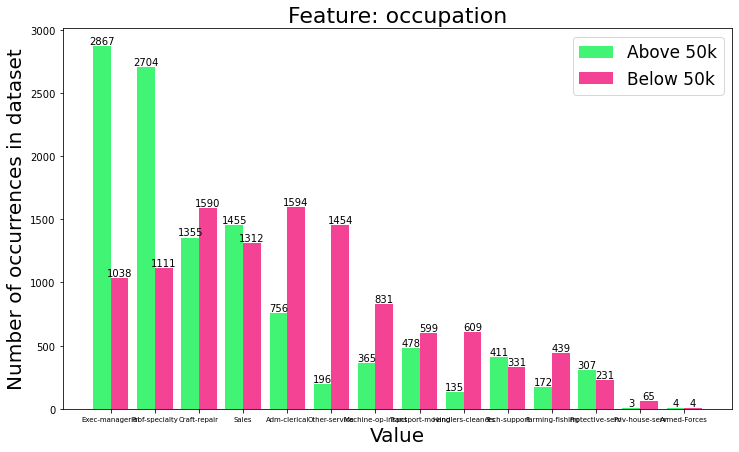

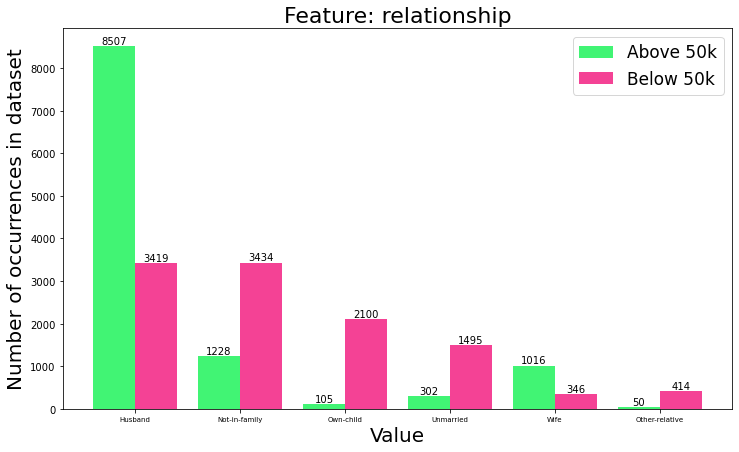

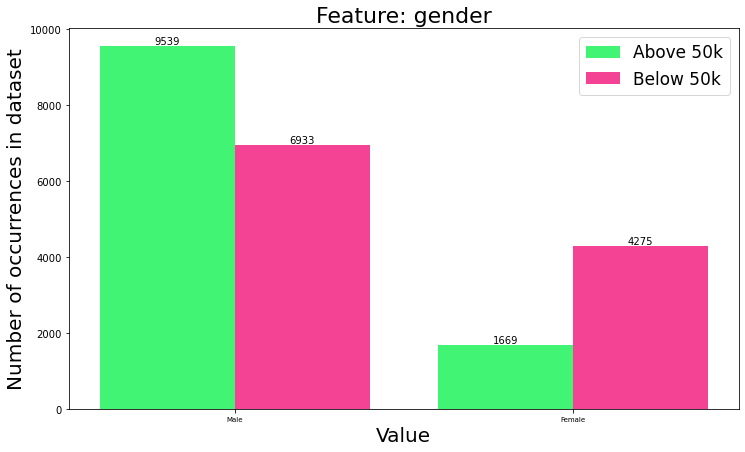

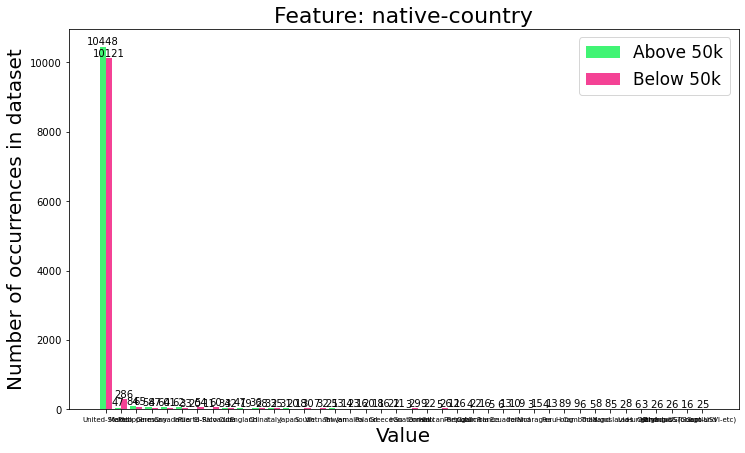

In [7]:
# 3.5: data statistics
verbose_print(data.describe())
categorical_feats = ['workclass', 'race', 'education', 'marital-status', 'occupation',
                    'relationship', 'gender', 'native-country', 'income']
for feature in categorical_feats:
    print("\n" + str(data[feature].value_counts()))
pie_chart(data, "workclass")
pie_chart(data, "race")
pie_chart(data, "education")
pie_chart(data, "marital-status")
pie_chart(data, "occupation")
pie_chart(data, "relationship")
pie_chart(data, "gender")
pie_chart(data, "native-country")
binary_bar_chart(data, "workclass")
binary_bar_chart(data, "race")
binary_bar_chart(data, "education")
binary_bar_chart(data, "marital-status")
binary_bar_chart(data, "occupation")
binary_bar_chart(data, "relationship")
binary_bar_chart(data, "gender")
binary_bar_chart(data, "native-country")

In [8]:
# Pi-chart functions
def verbose_print(data):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(data.head())

def random_color():
    return list(np.random.choice(range(256), size=3))

def pie_chart(dataset, column):
    col = dataset[column].value_counts()
    col_vals = col.values.tolist()
    col_types = col.axes[0].tolist()

    colors = [random_color() for i in range(len(col_types))]
    colors = ['#%02x%02x%02x' % tuple(x) for x in colors]

    fig = plt.figure(figsize=(12, 8))

    # Plot
    plt.title('Feature: {}'.format(column), fontsize=20)
    patches, texts, autotexts = plt.pie(col_vals, labels=col_types, colors=colors,
                                        autopct='%1.1f%%', shadow=True, startangle=150)
    for text, autotext in zip(texts, autotexts):
        text.set_fontsize(14)
        autotext.set_fontsize(14)

    plt.axis('equal')
    plt.show()

def autolabel(ax, rects, fontsize=14):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)

def binary_bar_chart(dataset, column):
    above_list = []
    below_list = []

    col_types = dataset[column].value_counts()
    col_labels = col_types.axes[0].tolist()

    for val in col_labels:
        total = len(dataset[dataset[column] == val].index)
        above = len(dataset[(dataset[column] == val) & (dataset['income'] == '>50K')].index)
        above_list.append(above)
        below_list.append(total - above)

    ind = np.arange(len(col_labels))  # the x locations for the groups

    width = 0.40
    fig, ax = plt.subplots(figsize=(12, 7))
    above_bars = ax.bar(ind, above_list, width, color='#41f474')
    below_bars = ax.bar(ind + width, below_list, width, color='#f44295')

    ax.set_xlabel("Value", fontsize=20)
    ax.set_ylabel('Number of occurrences in dataset', fontsize=20)
    ax.set_title('Feature: {}'.format(column), fontsize=22)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(col_labels,
                       fontsize=7)
    ax.legend((above_bars, below_bars), ('Above 50k', 'Below 50k'), fontsize=17)
    autolabel(ax, above_bars, 10)
    autolabel(ax, below_bars, 10)
    plt.show()

In [9]:
# 3.6: data preprocessing
cts_data_un = data.drop(columns=categorical_feats)
cts_data = ((cts_data_un-cts_data_un.mean())/cts_data_un.std()).values
cat_data = data[categorical_feats].copy()
le = LabelEncoder()
for col in cat_data.columns:
    cat_data[col] = le.fit_transform(cat_data[col])
y = cat_data['income']
cat_data = cat_data.drop(columns=['income'])
Xb = np.concatenate([cts_data_un.values, cat_data.values], axis=1) # Bonus
y = y.values 
enc = OneHotEncoder()
cat_onehot = enc.fit_transform(cat_data).toarray()
X = np.concatenate([cts_data, cat_onehot], axis=1)
print("Shape of X =", X.shape)

Shape of X = (22416, 103)


In [10]:
# 3.7: make the train and validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, random_state=seed)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, y, test_size=ts, random_state=seed)

In [11]:
# 4.1: Dataset
class AdultDataset(dt.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [12]:
# 4.2: DataLoader
def load_data(batch_size, train_D, train_l, test_D, test_l):
    train = AdultDataset(train_D,train_l)
    test = AdultDataset(test_D,test_l)
    train_loader = dt.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    val_loader = dt.DataLoader(dataset=test, batch_size=batch_size)
    return train_loader, val_loader

In [13]:
# 4.3: Model
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size):
        super(MultiLayerPerceptron, self).__init__()
        if numLayers == 1:
            self.fc1 = nn.Linear(input_size,1)
        elif numLayers == 2:
            self.fc1 = nn.Linear(input_size,hidden_size)
            self.fc2 = nn.Linear(hidden_size,1)
        elif numLayers == 4:
            self.fc1 = nn.Linear(input_size,hidden_size)
            self.fc2 = nn.Linear(hidden_size,hidden_size)
            self.fc3 = nn.Linear(hidden_size,hidden_size)
            self.fc4 = nn.Linear(hidden_size,1)
    def forward(self, features):
        feat = 0
        if act_fcn == "relu":
            feat = F.relu
        elif act_fcn == "tanh":
            feat = torch.tanh
        elif act_fcn == "sigmoid":
            feat = torch.sigmoid
        if numLayers == 1:
            features = torch.sigmoid(self.fc1(features))
        elif numLayers == 2:
            features = feat(self.fc1(features))
            features = torch.sigmoid(self.fc2(features))
        elif numLayers == 4:
            features = feat(self.fc1(features))
            features = feat(self.fc2(features))
            features = feat(self.fc3(features))
            features = torch.sigmoid(self.fc4(features))
        return features

In [14]:
# 4.4: Loss function and optimizer
def load_model(lr,dat):
    model = MultiLayerPerceptron(dat.shape[1])
    loss_fnc = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr)
    return model, loss_fnc, optimizer

In [15]:
# 4.6: Validation
def evaluate(model, val_loader):
    total_corr = 0
    for i, (inputs, labels) in enumerate(val_loader):
        index = 0
        predictions = model(inputs.float())
        for c in predictions.flatten():
            if (c.item()>0.5):
                r=1.0
            else:
                r=0.0
            if r==labels[index].item():
                total_corr += 1
            index += 1
    return float(total_corr)/len(val_loader.dataset)

In [16]:
mlp_o, loss_func, optm = load_model(learn_rate,X)
mlp_ob, lossb_func, optmb = load_model(learn_rate,Xb)
tr_load, val_load = load_data(bs,X_train,y_train,X_test,y_test)
trb_load, valb_load = load_data(bs,Xb_train,yb_train,Xb_test,yb_test)

In [17]:
# 4.5: Training Loop
def main(t_load, v_load, MLP, opt, loss_f):
    v_AccPerN = []
    t_AvgAccPerN = []
    t_c_avg = []
    time_step = []
    start = time()
    for e in range(epochs):
        print("Epoch: %d" % (e+1))
        t_correct_pred = 0
        for i, (t_inputs, t_labels) in enumerate(t_load):
            t_c = 0
            opt.zero_grad()
            t_predict = MLP(t_inputs.float())
            loss = loss_f(input=t_predict.flatten(),target=t_labels.float())
            loss.backward()
            opt.step()
            for j in range(len(t_predict)):
                if (t_predict[j] >= 0.5 and t_labels[j] == 1) or (t_predict[j] < 0.5 and t_labels[j] == 0):
                    t_c += 1
            t_correct_pred += t_c
            t_c_avg += [t_c/t_predict.shape[0]]
            if i%N==N-1:
                v_c = evaluate(MLP,v_load)
                v_AccPerN += [v_c]
                t_AvgAccPerN += [np.average(t_c_avg)]
                time_step += [time()-start]
                t_c_avg = []
                print("N: %d Loss: %f Correct Predictions (out of %d): %d Validation Accuracy: %f" % (i+1, loss.item(), i*bs+t_predict.shape[0], t_correct_pred, v_c))
    print("Validation accuracy: %f" % v_AccPerN[-1])
    print("Total time: %f" % time_step[-1])
    return v_AccPerN, t_AvgAccPerN, time_step

Epoch: 1
N: 10 Loss: 0.243652 Correct Predictions (out of 640): 362 Validation Accuracy: 0.628234
N: 20 Loss: 0.241314 Correct Predictions (out of 1280): 775 Validation Accuracy: 0.693131
N: 30 Loss: 0.236631 Correct Predictions (out of 1920): 1233 Validation Accuracy: 0.723461
N: 40 Loss: 0.225258 Correct Predictions (out of 2560): 1697 Validation Accuracy: 0.754237
N: 50 Loss: 0.216223 Correct Predictions (out of 3200): 2167 Validation Accuracy: 0.767618
N: 60 Loss: 0.223446 Correct Predictions (out of 3840): 2663 Validation Accuracy: 0.772302
N: 70 Loss: 0.195025 Correct Predictions (out of 4480): 3164 Validation Accuracy: 0.780553
N: 80 Loss: 0.179976 Correct Predictions (out of 5120): 3672 Validation Accuracy: 0.782783
N: 90 Loss: 0.165479 Correct Predictions (out of 5760): 4181 Validation Accuracy: 0.786128
N: 100 Loss: 0.160288 Correct Predictions (out of 6400): 4694 Validation Accuracy: 0.788359
N: 110 Loss: 0.169730 Correct Predictions (out of 7040): 5190 Validation Accuracy: 

N: 70 Loss: 0.107223 Correct Predictions (out of 4480): 3642 Validation Accuracy: 0.817351
N: 80 Loss: 0.139879 Correct Predictions (out of 5120): 4161 Validation Accuracy: 0.818466
N: 90 Loss: 0.118560 Correct Predictions (out of 5760): 4684 Validation Accuracy: 0.818689
N: 100 Loss: 0.175537 Correct Predictions (out of 6400): 5226 Validation Accuracy: 0.816905
N: 110 Loss: 0.125505 Correct Predictions (out of 7040): 5745 Validation Accuracy: 0.819135
N: 120 Loss: 0.076471 Correct Predictions (out of 7680): 6275 Validation Accuracy: 0.815566
N: 130 Loss: 0.124757 Correct Predictions (out of 8320): 6808 Validation Accuracy: 0.816682
N: 140 Loss: 0.135899 Correct Predictions (out of 8960): 7337 Validation Accuracy: 0.815120
N: 150 Loss: 0.135425 Correct Predictions (out of 9600): 7839 Validation Accuracy: 0.817574
N: 160 Loss: 0.130551 Correct Predictions (out of 10240): 8361 Validation Accuracy: 0.817797
N: 170 Loss: 0.141665 Correct Predictions (out of 10880): 8874 Validation Accuracy

N: 130 Loss: 0.074605 Correct Predictions (out of 8320): 6820 Validation Accuracy: 0.822703
N: 140 Loss: 0.105728 Correct Predictions (out of 8960): 7347 Validation Accuracy: 0.823149
N: 150 Loss: 0.132891 Correct Predictions (out of 9600): 7887 Validation Accuracy: 0.825602
N: 160 Loss: 0.096987 Correct Predictions (out of 10240): 8425 Validation Accuracy: 0.825379
N: 170 Loss: 0.124040 Correct Predictions (out of 10880): 8960 Validation Accuracy: 0.824487
N: 180 Loss: 0.146876 Correct Predictions (out of 11520): 9476 Validation Accuracy: 0.822926
N: 190 Loss: 0.144074 Correct Predictions (out of 12160): 10001 Validation Accuracy: 0.824487
N: 200 Loss: 0.138519 Correct Predictions (out of 12800): 10523 Validation Accuracy: 0.822926
N: 210 Loss: 0.102080 Correct Predictions (out of 13440): 11059 Validation Accuracy: 0.824487
N: 220 Loss: 0.138141 Correct Predictions (out of 14080): 11563 Validation Accuracy: 0.824710
N: 230 Loss: 0.105663 Correct Predictions (out of 14720): 12085 Valid

N: 190 Loss: 0.126790 Correct Predictions (out of 12160): 9999 Validation Accuracy: 0.828501
N: 200 Loss: 0.127472 Correct Predictions (out of 12800): 10508 Validation Accuracy: 0.828055
N: 210 Loss: 0.104160 Correct Predictions (out of 13440): 11035 Validation Accuracy: 0.828055
N: 220 Loss: 0.107595 Correct Predictions (out of 14080): 11574 Validation Accuracy: 0.828055
N: 230 Loss: 0.098440 Correct Predictions (out of 14720): 12104 Validation Accuracy: 0.828055
N: 240 Loss: 0.091278 Correct Predictions (out of 15360): 12639 Validation Accuracy: 0.829393
N: 250 Loss: 0.083549 Correct Predictions (out of 16000): 13174 Validation Accuracy: 0.828278
N: 260 Loss: 0.152773 Correct Predictions (out of 16640): 13708 Validation Accuracy: 0.828947
N: 270 Loss: 0.138730 Correct Predictions (out of 17280): 14240 Validation Accuracy: 0.828055
N: 280 Loss: 0.107335 Correct Predictions (out of 17920): 14777 Validation Accuracy: 0.827163
Epoch: 11
N: 10 Loss: 0.126043 Correct Predictions (out of 64

N: 250 Loss: 0.121288 Correct Predictions (out of 16000): 13242 Validation Accuracy: 0.824264
N: 260 Loss: 0.160195 Correct Predictions (out of 16640): 13762 Validation Accuracy: 0.826717
N: 270 Loss: 0.112324 Correct Predictions (out of 17280): 14281 Validation Accuracy: 0.826717
N: 280 Loss: 0.123303 Correct Predictions (out of 17920): 14791 Validation Accuracy: 0.825379
Epoch: 14
N: 10 Loss: 0.153649 Correct Predictions (out of 640): 514 Validation Accuracy: 0.827386
N: 20 Loss: 0.107434 Correct Predictions (out of 1280): 1050 Validation Accuracy: 0.829170
N: 30 Loss: 0.114579 Correct Predictions (out of 1920): 1581 Validation Accuracy: 0.828724
N: 40 Loss: 0.152602 Correct Predictions (out of 2560): 2112 Validation Accuracy: 0.826717
N: 50 Loss: 0.100521 Correct Predictions (out of 3200): 2658 Validation Accuracy: 0.823595
N: 60 Loss: 0.096177 Correct Predictions (out of 3840): 3197 Validation Accuracy: 0.829839
N: 70 Loss: 0.096640 Correct Predictions (out of 4480): 3731 Validatio

N: 20 Loss: 0.110413 Correct Predictions (out of 1280): 1070 Validation Accuracy: 0.829170
N: 30 Loss: 0.156348 Correct Predictions (out of 1920): 1599 Validation Accuracy: 0.830731
N: 40 Loss: 0.106094 Correct Predictions (out of 2560): 2132 Validation Accuracy: 0.830285
N: 50 Loss: 0.140071 Correct Predictions (out of 3200): 2662 Validation Accuracy: 0.830508
N: 60 Loss: 0.154633 Correct Predictions (out of 3840): 3198 Validation Accuracy: 0.829839
N: 70 Loss: 0.139357 Correct Predictions (out of 4480): 3700 Validation Accuracy: 0.827163
N: 80 Loss: 0.075660 Correct Predictions (out of 5120): 4223 Validation Accuracy: 0.830508
N: 90 Loss: 0.150604 Correct Predictions (out of 5760): 4777 Validation Accuracy: 0.826494
N: 100 Loss: 0.107489 Correct Predictions (out of 6400): 5303 Validation Accuracy: 0.830508
N: 110 Loss: 0.099021 Correct Predictions (out of 7040): 5834 Validation Accuracy: 0.830955
N: 120 Loss: 0.100310 Correct Predictions (out of 7680): 6376 Validation Accuracy: 0.828

N: 70 Loss: 0.099044 Correct Predictions (out of 4480): 3692 Validation Accuracy: 0.830285
N: 80 Loss: 0.105310 Correct Predictions (out of 5120): 4231 Validation Accuracy: 0.828501
N: 90 Loss: 0.145964 Correct Predictions (out of 5760): 4768 Validation Accuracy: 0.829616
N: 100 Loss: 0.142386 Correct Predictions (out of 6400): 5298 Validation Accuracy: 0.830955
N: 110 Loss: 0.110762 Correct Predictions (out of 7040): 5833 Validation Accuracy: 0.829393
N: 120 Loss: 0.124305 Correct Predictions (out of 7680): 6355 Validation Accuracy: 0.827609
N: 130 Loss: 0.132754 Correct Predictions (out of 8320): 6885 Validation Accuracy: 0.830508
N: 140 Loss: 0.157473 Correct Predictions (out of 8960): 7415 Validation Accuracy: 0.830062
N: 150 Loss: 0.124140 Correct Predictions (out of 9600): 7942 Validation Accuracy: 0.831178
N: 160 Loss: 0.126320 Correct Predictions (out of 10240): 8471 Validation Accuracy: 0.829170
N: 170 Loss: 0.135394 Correct Predictions (out of 10880): 8984 Validation Accuracy

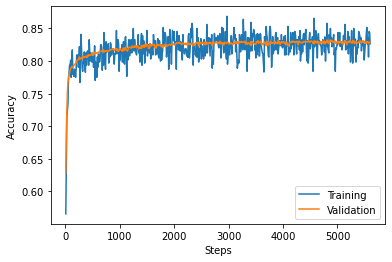

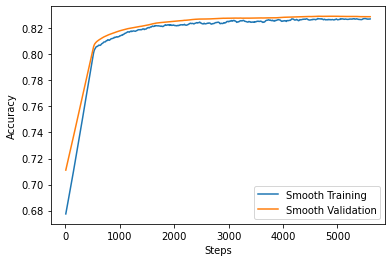

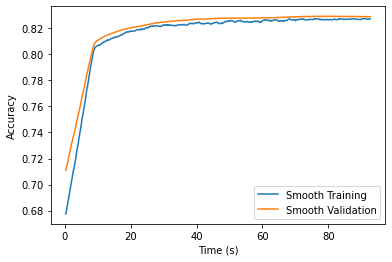

In [18]:
v_acc, t_acc, runtime = main(tr_load, val_load, mlp_o, optm, loss_func) # For bonus, change to trb_load, valb_load, mlp_ob, optmb, lossb_func
# Plots
freq = list(range(N,N*len(v_acc)+N,N))
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.plot(freq,t_acc,label="Training")
plt.plot(freq,v_acc,label="Validation")
plt.legend()
plt.show()
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.plot(freq,savgol_filter(t_acc,101,1,mode='nearest'),label="Smooth Training")
plt.plot(freq,savgol_filter(v_acc,101,1,mode='nearest'),label="Smooth Validation")
plt.legend()
plt.show()
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.plot(runtime,savgol_filter(t_acc,101,1,mode='nearest'),label="Smooth Training")
plt.plot(runtime,savgol_filter(v_acc,101,1,mode='nearest'),label="Smooth Validation")
plt.legend()
plt.show()